In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class MultiFolderSARUpscalingDataset(Dataset):
    def __init__(self, root_dir, scale_factor=2, transform=None):
        """
        Args:
            root_dir (string): Root directory containing all the subfolders for each terrain type.
            scale_factor (int): Factor by which to downscale and then upscale the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.transform = transform
        self.image_files = []

        # Traverse all subfolders and collect image paths
        for terrain_type in os.listdir(root_dir):
            sar_dir = os.path.join(root_dir, terrain_type, "s1")
            sar_images = sorted(os.listdir(sar_dir))
            for sar_img in sar_images:
                sar_path = os.path.join(sar_dir, sar_img)
                self.image_files.append(sar_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        sar_path = self.image_files[idx]

        # Load the SAR image
        sar_image = Image.open(sar_path).convert("L")  # SAR images are grayscale

        # Downscale the image
        low_res_image = sar_image.resize(
            (
                sar_image.width // self.scale_factor,
                sar_image.height // self.scale_factor,
            ),
            Image.BICUBIC,
        )

        # Upscale back to original size
        low_res_image = low_res_image.resize(sar_image.size, Image.BICUBIC)

        if self.transform:
            low_res_image = self.transform(low_res_image)
            sar_image = self.transform(sar_image)

        return (
            low_res_image,
            sar_image,
        )  # low_res_image is the input, sar_image is the target

In [2]:
# Define image transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images to [-1, 1]
    ]
)

In [3]:
# Define the path to the root directory containing the subfolders
root_dir = "data/v_2"

# Create the dataset
dataset = MultiFolderSARUpscalingDataset(
    root_dir=root_dir, scale_factor=2, transform=transform
)

# Create DataLoader for batching
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [4]:
import torch.nn as nn


class UpscalingCNN(nn.Module):
    def __init__(self):
        super(UpscalingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        return x

In [5]:
import torch.nn as nn


class UpscalingCNN(nn.Module):
    def __init__(self):
        super(UpscalingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        return x

In [6]:
from torch.optim.adam import Adam

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UpscalingCNN().to(device)
criterion = nn.MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [7]:
num_epochs = 50  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.0081
Epoch [2/50], Loss: 0.0068
Epoch [3/50], Loss: 0.0067
Epoch [4/50], Loss: 0.0066
Epoch [5/50], Loss: 0.0066
Epoch [6/50], Loss: 0.0065
Epoch [7/50], Loss: 0.0065
Epoch [8/50], Loss: 0.0065
Epoch [9/50], Loss: 0.0069
Epoch [10/50], Loss: 0.0065
Epoch [11/50], Loss: 0.0065
Epoch [12/50], Loss: 0.0065
Epoch [13/50], Loss: 0.0065
Epoch [14/50], Loss: 0.0064
Epoch [15/50], Loss: 0.0064
Epoch [16/50], Loss: 0.0064
Epoch [17/50], Loss: 0.0064
Epoch [18/50], Loss: 0.0064
Epoch [19/50], Loss: 0.0064
Epoch [20/50], Loss: 0.0064
Epoch [21/50], Loss: 0.0064
Epoch [22/50], Loss: 0.0064
Epoch [23/50], Loss: 0.0064
Epoch [24/50], Loss: 0.0064
Epoch [25/50], Loss: 0.0064
Epoch [26/50], Loss: 0.0064
Epoch [27/50], Loss: 0.0064
Epoch [28/50], Loss: 0.0064
Epoch [29/50], Loss: 0.0064
Epoch [30/50], Loss: 0.0064
Epoch [31/50], Loss: 0.0064
Epoch [32/50], Loss: 0.0064
Epoch [33/50], Loss: 0.0063
Epoch [34/50], Loss: 0.0063
Epoch [35/50], Loss: 0.0063
Epoch [36/50], Loss: 0.0063
E

In [8]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

model.eval()
psnr_list = []
ssim_list = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        outputs_np = outputs.cpu().numpy().squeeze(1)
        targets_np = targets.cpu().numpy().squeeze(1)

        for j in range(outputs_np.shape[0]):
            output_img = outputs_np[j]
            target_img = targets_np[j]

            # Calculate PSNR
            psnr_value = peak_signal_noise_ratio(
                target_img, output_img, data_range=target_img.max() - target_img.min()
            )
            psnr_list.append(psnr_value)

            # Calculate SSIM
            ssim_value = structural_similarity(
                target_img, output_img, data_range=target_img.max() - target_img.min()
            )
            ssim_list.append(ssim_value)

    print(f"Validation PSNR: {np.mean(psnr_list):.4f}")
    print(f"Validation SSIM: {np.mean(ssim_list):.4f}")

Validation PSNR: 28.1556
Validation SSIM: 0.9219


In [9]:
torch.save(model.state_dict(), "models/upscaling_model.pth")

/tmp/ipykernel_5404/3678933169.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/upscaling_model.pth"), strict=True)


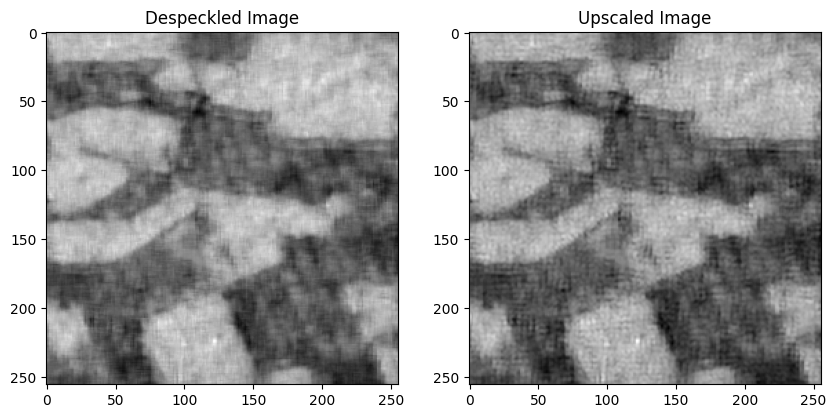

In [21]:
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UpscalingCNN().to(device)

# Load the model weights
model.load_state_dict(torch.load("models/upscaling_model.pth"), strict=True)
model.eval()

# Define the image transformation (should match the one used during training)
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images to [-1, 1]
    ]
)

# Load and preprocess the test image
# image_path = "models/despeckled_output.png"
image_path = "models/despeckled_output.png"
sar_image = Image.open(image_path).convert("L")
sar_image = transform(sar_image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(sar_image)

# Post-process and visualize the result
output_image = output.squeeze(0).cpu().numpy().squeeze(0)
output_image = (
    output_image * 0.5 + 0.5
) * 255  # De-normalize and scale back to [0, 255]
output_image = output_image.astype("uint8")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Despeckled Image")
plt.imshow(sar_image.cpu().squeeze(0).squeeze(0).numpy() * 0.5 + 0.5, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Upscaled Image")
plt.imshow(output_image, cmap="gray")
plt.show()


output_image_pil = Image.fromarray(output_image)
output_image_pil.save("models/upscaled_output.png")